# Objective

We will be replicating the paper "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale" by implementing its Vision Transformer (ViT) architecture in code. The link to the research paper is here: [ViT Research Paper](https://arxiv.org/abs/2010.11929)

# Warning

Before running this code, make sure your kaggle.json file (which contains your Kaggle API key) is uploaded to the file system (left panel) if you're using Google Colab.

# Import Torch

In [1]:
import torch

# Device Agnostic Code

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Get Data

We will use a Kaggle dataset containing images from six classes: buildings, forest, glacier, mountain, sea, and street, to evaluate how our Vision Transformer model performs when trained from scratch.

Here is the link to it: [https://www.kaggle.com/code/evgenyzorin/intel-image-classification](https://www.kaggle.com/code/evgenyzorin/intel-image-classification)

## Load Kaggle Dataset

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/intel-image-classification


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls -l ~/.kaggle/
!kaggle datasets download puneet6060/intel-image-classification -p data --unzip

total 4
-rw-r--r-- 1 root root 66 Aug  4 18:20 kaggle.json
Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 96% 331M/346M [00:00<00:00, 641MB/s]
100% 346M/346M [00:00<00:00, 678MB/s]


## Remove unnecessary directories

In [5]:
!rm -r "/content/data/seg_pred"

## Create image path

In [6]:
from pathlib import Path
image_path = Path("/content/data")
image_path

PosixPath('/content/data')

## Create training and testing directories

In [7]:
train_dir = image_path / "seg_train" / "seg_train" # creating a Poxis path for our training directory
test_dir = image_path / "seg_test" / "seg_test" # creating a Poxis path for our testing directory

train_dir, test_dir

(PosixPath('/content/data/seg_train/seg_train'),
 PosixPath('/content/data/seg_test/seg_test'))

## Create Datasets and DataLoaders

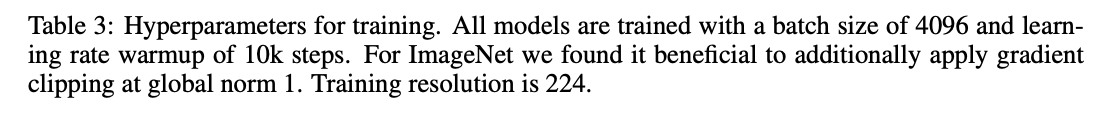

_Table 3 of the ViT paper_

In Table 3 of the research paper, the input image size for the Vision Transformer is 224×224 pixels.

It’s also trained with a batch size of 4096. Since Google Colab’s free GPU probably can’t handle that many images at once, we’ll use a batch size of 32 instead.

### Create custom transform

In [8]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

IMG_SIZE = 224 # Training resolution as stated earlier.

custom_transforms = transforms.Compose([ # Resize images and convert to tensor
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {custom_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


### Create Datasets

In [9]:
# Use ImageFolder to create a dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=custom_transforms, # a transform for the data
                                  target_transform=None)    # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=custom_transforms)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 14034
     Root location: /content/data/seg_train/seg_train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 3000
     Root location: /content/data/seg_test/seg_test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

### Create Dataloaders

In [10]:
# Turn train and test datasets into DataLoaders.
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True) # Shuffle data because it helps model generalize better.

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7c3f02c51e90>,
 <torch.utils.data.dataloader.DataLoader at 0x7c3f030f8790>)

In [11]:
len(train_dataloader), len(test_dataloader)

(439, 94)

### Our class names

In [83]:
class_names = train_data.classes # gets all the class names in the training data
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

### Visualizing a single image

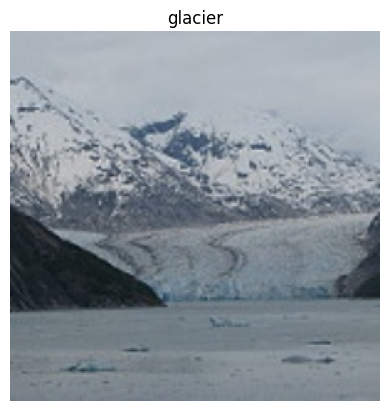

In [37]:
image_batch, label_batch = next(iter(train_dataloader)) # iterating through a single batch in the dataloader

image, label = image_batch[0], label_batch[0] # getting a single image and its label in the batch of the iterated dataloader

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

# Explaining the ViT Architecture and It's Functions

## The Basics Of the Vision Transformer

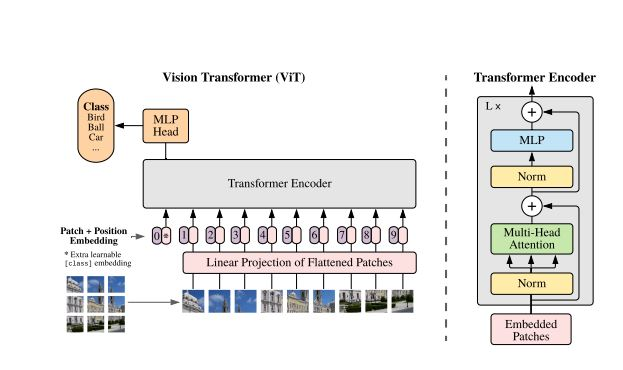

_Figure 1 of the ViT paper_

### ViT Workflow:

* Patch + Position Embedding (inputs) - Transforms the input image into a sequence of image patches by dividing it into fixed-size blocks. Each patch is flattened and embedded into a vector. A positional embedding is added to each patch to retain the original spatial order, since transformers do not inherently understand position.

* Linear Projection of Flattened Patches (Embedded Patches) - Each flattened image patch is passed through a linear layer to convert it into a learnable embedding vector. These vectors are used as input tokens to the transformer.

* Norm (Layer Normalization) - Also known as "Layer Norm," it normalizes inputs across features to stabilize training and improve gradient flow. It is used frequently in transformer blocks before attention and MLP layers. While it may have some regularization benefits, its main purpose is not to reduce overfitting, but to help training stability.

* Multi-Head Attention - Comprised of an MSA layer, or in other words, a "Multi-Headed Self-Attention" layer. This mechanism allows the model to attend to information from different positions (patches) simultaneously by using multiple attention heads.

* Multilayer Perceptron (MLP) - A group of feedforward layers that includes linear transformations, non-linear activation functions (like GELU), and dropout for regularization. This block helps in learning complex transformations of the input tokens.

* Transformer Encoder - A stack of the components mentioned above (Layer Norm, Multi-Head Attention, MLP). Each encoder block has two residual (skip) connections (represented by the "+" symbol) that add the input of a sub-layer to its output. Multiple encoder blocks are stacked to build the full Vision Transformer architecture.

* MLP Head - This is the architecture's output layer. It takes the final embedding (usually from a special [CLS] token) and maps it to class scores through a feedforward network. It is also known as the "classifier head."

## The 4 Core Equations

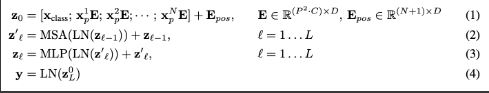

_Found in section 3.1 of the ViT paper_

* Equation 1: The Transformer utilizes a constant latent vector size $D$ throughout all the layers of the Transformer.

* The Transformer Encoder is made up of layers alternating between Multi-Head Self-Attention (MSA) and Multilayer Perceptron (MLP) blocks. LayerNorm (LN) is applied to the embedded patches before each block, and residual connections are applied to the outputs of these blocks.

* Equation 3: Same as Equation 2.

* Equation 4: Similar to BERT’s [CLS] token, we prepend a learnable embedding to the sequence of embedded patches, $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$. The state of this token at the output of the Transformer encoder, $\left(\mathbf{z}_L^0\right)$, is then used as the image representation $\mathbf{y}$.

### Equation 1 Overview

$$
\begin{aligned}
\mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}
\end{aligned}
$$

This equation represents the concatenation of the class token and the patch embeddings of the input image, followed by the addition of the positional embeddings $\mathbf{E}_{\text{pos}}$.

### Equation 2 Overview

$$
\mathbf{z}_{\ell}^{\prime} = \mathrm{MSA} \left( \mathrm{LN} \left( \mathbf{z}_{\ell-1} \right) \right) + \mathbf{z}_{\ell-1}, \quad \ell = 1 \ldots L
$$

This equation describes the Multi-Head Self-Attention (MSA) block used in each Transformer layer.  
For every layer from $\ell = 1$ to $L$, where $L$ is the total number of layers, the input $\mathbf{z}_{\ell-1}$ is first passed through Layer Normalization (LN), then through a Multi-Head Self-Attention mechanism.  
The output of this operation is then added back to the original input via a residual connection.

This structure is referred to as the **MSA block**.


### Equation 3 Overview

$$
\begin{aligned}
\mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\end{aligned}a
$$

This equation describes the second part of the Transformer encoder block. For each layer from $1$ to $L$ (where $L$ is the total number of layers), the output $\mathbf{z}\ell'$ is first passed through a LayerNorm (LN), then through a Multilayer Perceptron (MLP), and finally added back to the original $\mathbf{z}\ell'$ using a residual connection.

### Equation 4 Overview

$$
\begin{aligned}
\mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & &
\end{aligned}
$$

In the final layer $L$, the image representation $\mathbf{y}$ is obtained by applying LayerNorm (LN) to the 0-th token (the [CLS] token) of the Transformer output $\mathbf{z}_L$.



## Table 1 Exploration

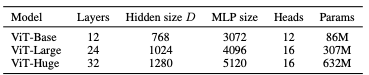

_Table 1 of the ViT paper_

This table showcases the key hyperparameters of different ViT architectures.

Because we want to save time training, we will replicate the **ViT-Base** model.

**Summary of Hyperparameters:**

* **Layers** – The number of Transformer Encoder blocks.
* **Hidden Size** $D$ – The dimension of the vector representing each image patch after embedding.
* **MLP Size** – The number of hidden units in the MLP layers inside each Transformer block.
* **Heads** – The number of attention heads in the multi-head self-attention (MSA) layers.
* **Params** – The total number of trainable parameters in the model.

# Replicating Equation 1

We are going to start with patch embedding, or in other words, creating a learnable representation of the image. We'll take the input images and divide them into sequential patches, then embed those patches — essentially turning them into learnable vector representations.

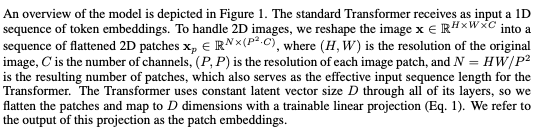

_Found in section 3.1 of the ViT paper_

Summarizing the text from above:

- $D$ is the size of the patch embeddings. Our size is 768 since we are replicating the ViT-Base architecture.

- The image begins in 2D form with size $H \times W \times C$, where $(H, W)$ is the resolution of the input image (height × width) and $C$ is the number of channels.

- The input image gets transformed into a sequence of 2D patches that are flattened to a size of $N \times (P^{2} \cdot C)$.

- $(P, P)$ is the resolution of each image patch, or in other words, the patch size.

- $N = \frac{H \times W}{P^{2}}$ is the total number of patches in the image, which is also the length of the input sequence that goes into the Transformer.

Let's make some variables in code to represent $H$ and $W$.

We will use a patch size $P$ of 16 because it provides the performance from the ViT-Base model according to Table 5 in the ViT research paper.


In [38]:
height = 224 # H (Since the training resolution is 224 if you look in the ViT paper)
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

number_of_patches = int((height * width) / patch_size**2) # Our total number of patches
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


Let's now mimic the input and output shapes of the patch embedding layer. Our input shape is how the image starts off, which is $H \times W \times C$. Our output shape is $N \times (P^{2} \cdot C)$, where the image is split into $N$ patches, and each patch is flattened into a vector of size $P^{2} \cdot C$.


In [39]:
# Input Shape
embedding_layer_input = (height, width, color_channels)

# Output Shape
embedding_layer_output = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


Before we start making the patch embedding layer, let's first visualize how an image looks in patches.

Let's begin with the image stored in the image variable that we created above for this demonstration.

If you don't remember what it was, here it is:

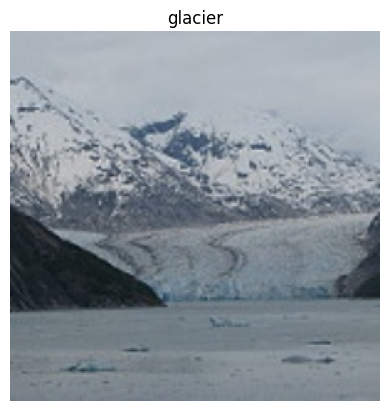

In [41]:
plt.imshow(image.permute(1,2,0)) # adjust for matplot lib
plt.title(class_names[label]) # title is the class name associated with the iamge
plt.axis(False); # turn off the axis for a more clear view

We want to convert this image into patches.

Let's use the bottom row of this image to demonstrate the patch conversion.

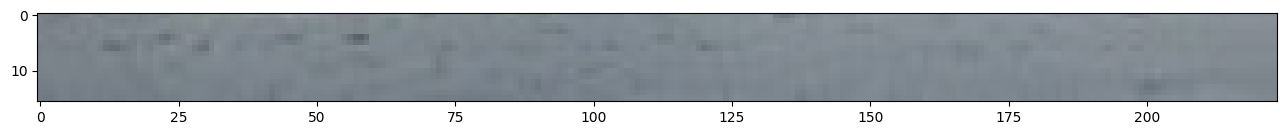

In [43]:
image_permuted = image.permute(1, 2, 0)
patch_size = 16 # P
plt.figure(figsize=(16, 16))
plt.imshow(image_permuted[-patch_size:, :, :]) # Indexes the bottom row

Let’s now turn this into patches by iterating over how many patches span the top row.

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


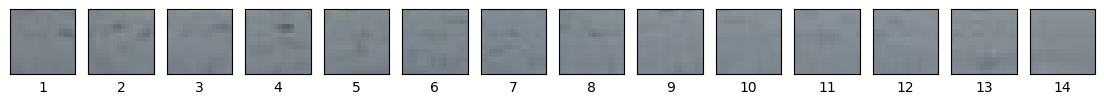

In [45]:
img_size = 224 # Training resolution
patch_size = 16 # P
patches_num  = img_size/patch_size #
print(f"Number of patches per row: {patches_num }\nPatch size: {patch_size} pixels x {patch_size} pixels")

fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # each patch is associated with one column
                        figsize=(patches_num , patches_num ),
                        sharex=True,
                        sharey=True)

# Loop over the patches along the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[-patch_size:, patch:patch+patch_size, :])  # bottom row: last patch_size rows, width moves as before
    axs[i].set_xlabel(i+1)  # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Now, let’s do this for the whole image.

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


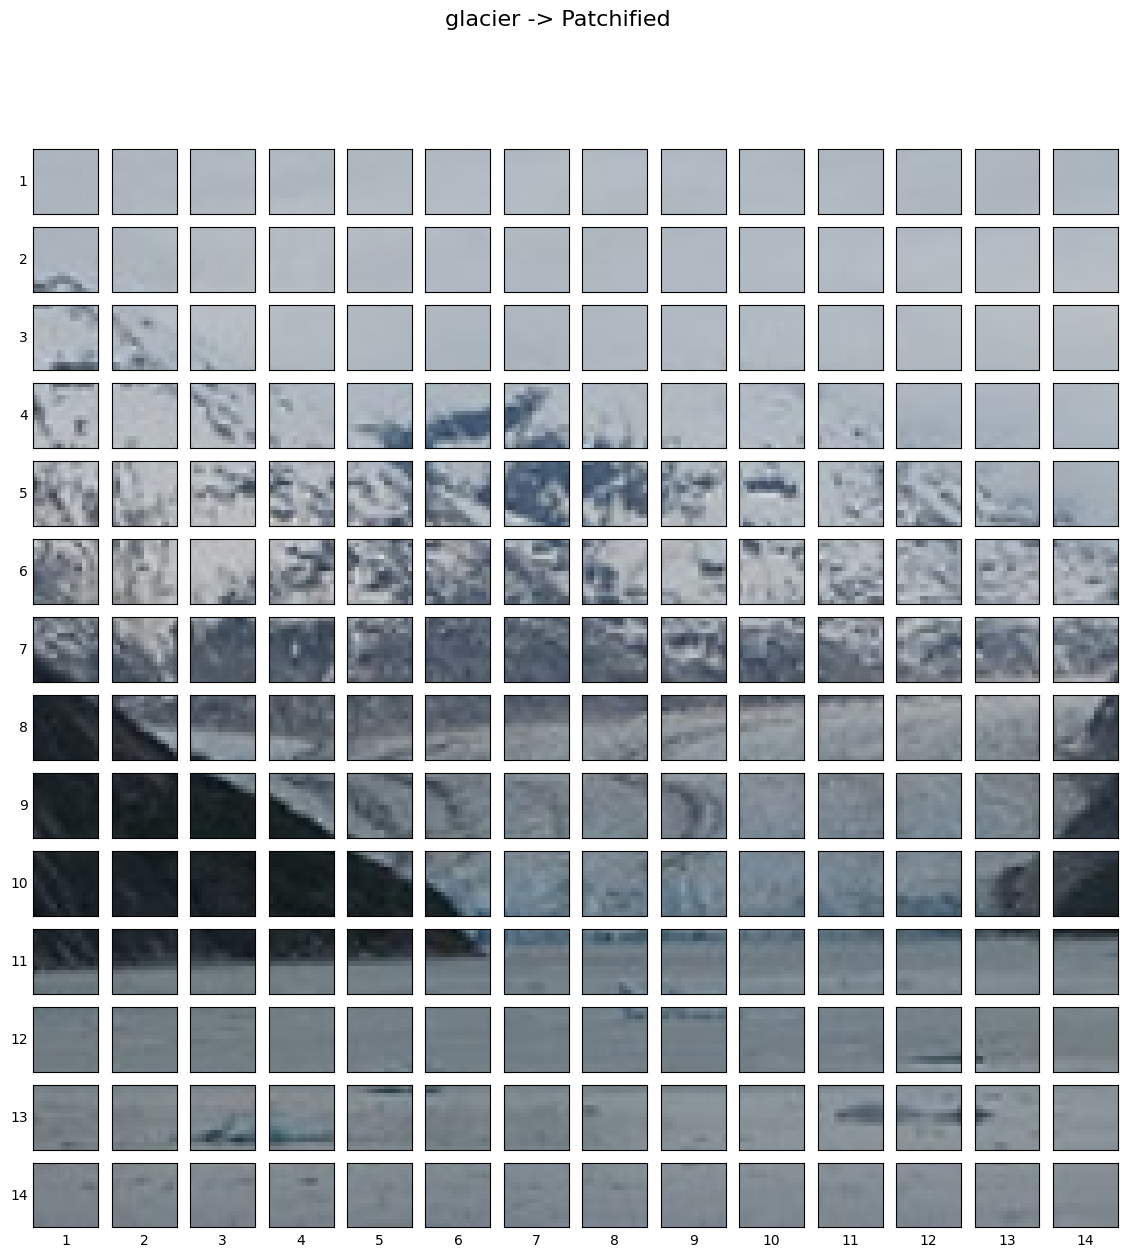

In [46]:
img_size = 224
patch_size = 16
patches_num = img_size/patch_size

# Print number of patches along each dimension and total patches
print(f"Number of patches per row: {patches_num }\
        \nNumber of patches per column: {patches_num }\
        \nTotal patches: {patches_num * patches_num }\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create subplots grid with number of patches per row and column
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(patches_num , patches_num ),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image to extract patches
for i, patch_height in enumerate(range(0, img_size, patch_size)):  # iterate over patch rows
    for j, patch_width in enumerate(range(0, img_size, patch_size)):  # iterate over patch columns

        # Display patch at (i,j) by slicing the image accordingly
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,  # height slice
                              patch_width:patch_width+patch_size,      # width slice
                              :])                                     # all color channels

        # Set y-axis label as the patch row number (rotated horizontally)
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")

        # Set x-axis label as the patch column number
        axs[i, j].set_xlabel(j+1)

        # Remove x and y ticks for cleaner look
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

        # Hide inner labels to avoid clutter on shared axes
        axs[i, j].label_outer()

# Set a main title for the entire figure showing class and that image is patchified
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)

# Show the plot with all patches visualized
plt.show()


Image is now patchified

Now that we know how an image looks in patches, let's start creating the patch embedding layers with PyTorch.

To visualize a single image, we loop through its height and width to show small patches. This is similar to how convolutional layers examine small parts of an image to better understand it.

In Section 3.1 of the ViT research paper, it is even mentioned that the patch embedding can be achieved with a CNN (convolutional neural network). Here is a picture of that text below.



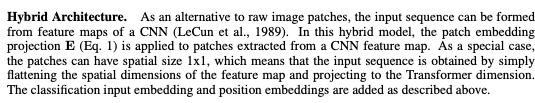

_Found in section 3.1 of the ViT paper_

The "feature map" mentioned here refers to the weights generated by a convolutional layer as it processes an image input.



If you recall, we previously calculated the ideal output shape using an image size of 224 and a patch size of 16.

- Input: (224, 224, 3) → (Height, Width, Color Channels)  
- Output: (196, 768) → (number of patches, embedding dimension)

We can create these output shapes with:  
- `torch.nn.Conv2d()`, which will convert our image into patches represented as CNN feature maps  
- `torch.nn.Flatten()`, which will flatten the spatial dimensions of the feature map

Let's begin with the `torch.nn.Conv2d()` step.

We recreate the patch construction by making the `kernel_size` and `stride` equal to `patch_size`. In other words, each convolutional kernel will have size `(patch_size \times patch_size)`, and each stride will move by `patch_size` pixels.

We will set `in_channels = 3`, which is the number of color channels in our input image, and `out_channels = 768`, which matches the embedding dimension \(D\) from Table 1 for the ViT-Base architecture — essentially converting our image into a learnable embedding vector of dimension 768.


In [47]:
from torch import nn

# Set the patch size
patch_size = 16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(
    in_channels=3,        # Number of color channels
    out_channels=768,     # Hidden size D (embedding dimension)
    kernel_size=patch_size,
    stride=patch_size,
    padding=0
)


Now let's pass an image through the convolutional layer we just created.


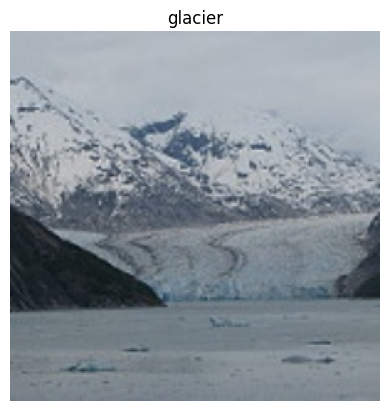

In [49]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [51]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0))  # Add batch dimension and rearrange dimensions
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Passing the image through this convolutional layer turns it into a series of 768 (the embedding size or \(D\)) feature maps.

Here is how the output shape of this convolutional layer can be interpreted:

```python
torch.Size([1, 768, 14, 14])  # [batch_size, embedding_dim, feature_map_height, feature_map_width]


Let's now visualize five random feature maps for learning purposes.

Showing random convolutional feature maps from indexes: [179, 517, 603, 634, 688]


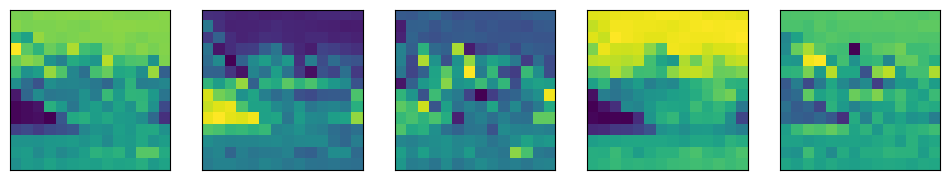

In [52]:
# Plot 5 random convolutional feature maps
import random
import matplotlib.pyplot as plt

random_idx = random.sample(range(0, 768), k=5)  # Pick 5 random indexes from 0 to 767 (embedding size)
print(f"Showing random convolutional feature maps from indexes: {random_idx}")

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot each selected feature map
for i, idx in enumerate(random_idx):
    feature_map = image_out_of_conv[:, idx, :, :]  # Select feature map by index
    axs[i].imshow(feature_map.squeeze().detach().cpu().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


Wow, look at that! As you can see in the feature maps above, they represent the original image in a different form. If you look at more of these feature maps, you can start to notice some major commonalities between them.

These features might change over time as the neural network begins training.

Let’s now check out one of these feature maps in numerical form.



In [53]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.5976, -0.6088, -0.6052, -0.6020, -0.6143, -0.6164, -0.6151,
           -0.6212, -0.6150, -0.6142, -0.6102, -0.6082, -0.6019, -0.5984],
          [-0.6353, -0.5996, -0.6181, -0.6214, -0.6118, -0.6152, -0.6067,
           -0.6074, -0.6107, -0.6178, -0.6177, -0.6183, -0.6225, -0.6210],
          [-0.5643, -0.5649, -0.6327, -0.6138, -0.6117, -0.6047, -0.6046,
           -0.6102, -0.6210, -0.6114, -0.6175, -0.6148, -0.6233, -0.6225],
          [-0.5782, -0.5918, -0.4703, -0.5864, -0.6268, -0.4018, -0.6217,
           -0.6639, -0.6198, -0.6094, -0.5590, -0.5932, -0.5977, -0.6092],
          [-0.6641, -0.6055, -0.5749, -0.5799, -0.6313, -0.6049, -0.3339,
           -0.3666, -0.5471, -0.5418, -0.5887, -0.5271, -0.5594, -0.5798],
          [-0.5167, -0.5295, -0.6662, -0.4165, -0.4637, -0.5237, -0.5014,
           -0.5403, -0.5267, -0.5681, -0.5580, -0.4343, -0.5509, -0.5912],
          [-0.4089, -0.5427, -0.3679, -0.3421, -0.3407, -0.3291, -0.3480,
           -0.4002, -0.4422, -0.

The presence of `grad_fn` and `requires_grad=True` on `feature_map` means that PyTorch is tracking its gradients, so it will be involved in backpropagation during training.

We have now turned our image into patch/learnable embeddings, but they are still in a 2D format.

Remember, the desired output shape is
(196,768), where 196 is the number of patches and 768 is the embedding dimension $D$.

Let’s take a look at our current shape.



In [54]:
# Current shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


We have the embedding dimension in our shape, but we still need the number of patches, which is 196 in our case. If you look at the image below:

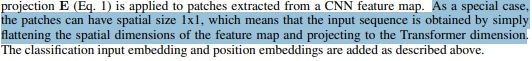

_Found in Section 3.1 of the ViT Research paper_

We need to flatten the spatial dimensions of the feature map and we can thankfully use `torch.nn.Flatten()` to do that.

We want to only flatten the spatial dimensions, so in our situation that is the feature_map_height and feature_map_width dimensions of image_out_of_conv.

So let's use `torch.nn.Flatten()` to create a flattening layer that flattens thome dimensions.

In [55]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Now let's put everything together:

1. Get a single image  
2. Pass it through the convolutional layer we made to convert it into feature maps  
3. Flatten those feature maps into a single sequential vector

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


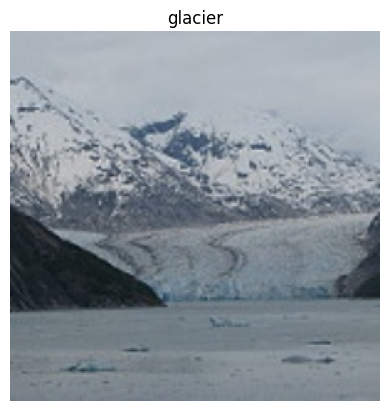

In [56]:
# 1. Get a single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Pass it through the convolutional layer we made to convert it into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten those feature maps into a single sequential vector
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

Our image is now almost in the desired shape—currently
(1,768,196) but we want (196,768); to fix this, we can use `torch.Tensor.permute().`

In [57]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, D, N] -> [batch_size, N, D]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


There we go! We now have our desired output shape for the patch embedding layer of the ViT architecture.

Let’s visualize one of the flattened feature maps.

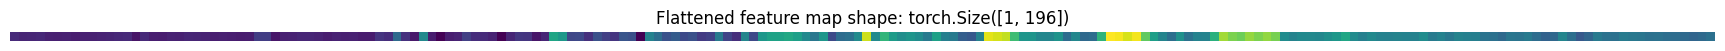

In [58]:
# Acquire a single flattened feature map
flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {flattened_feature_map.shape}")
plt.axis(False);

This is how the output of the patch embedding layer looks for a single image.

Let’s take a look at this flattened feature map in tensor form.

In [59]:
# See the single flattened feature map as a tensor
flattened_feature_map, flattened_feature_map.requires_grad, flattened_feature_map.shape

(tensor([[-0.5976, -0.6088, -0.6052, -0.6020, -0.6143, -0.6164, -0.6151, -0.6212,
          -0.6150, -0.6142, -0.6102, -0.6082, -0.6019, -0.5984, -0.6353, -0.5996,
          -0.6181, -0.6214, -0.6118, -0.6152, -0.6067, -0.6074, -0.6107, -0.6178,
          -0.6177, -0.6183, -0.6225, -0.6210, -0.5643, -0.5649, -0.6327, -0.6138,
          -0.6117, -0.6047, -0.6046, -0.6102, -0.6210, -0.6114, -0.6175, -0.6148,
          -0.6233, -0.6225, -0.5782, -0.5918, -0.4703, -0.5864, -0.6268, -0.4018,
          -0.6217, -0.6639, -0.6198, -0.6094, -0.5590, -0.5932, -0.5977, -0.6092,
          -0.6641, -0.6055, -0.5749, -0.5799, -0.6313, -0.6049, -0.3339, -0.3666,
          -0.5471, -0.5418, -0.5887, -0.5271, -0.5594, -0.5798, -0.5167, -0.5295,
          -0.6662, -0.4165, -0.4637, -0.5237, -0.5014, -0.5403, -0.5267, -0.5681,
          -0.5580, -0.4343, -0.5509, -0.5912, -0.4089, -0.5427, -0.3679, -0.3421,
          -0.3407, -0.3291, -0.3480, -0.4002, -0.4422, -0.3707, -0.5386, -0.4673,
          -0.455

Great! We have now sucessfully turned our single 2D image into a 1D learnable embedding vector

Let’s turn this patch embedding process into a PyTorch module.

We will subclass`nn.Module` and create a module that performs all the steps we covered above.

In [60]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        # 3. Create a layer that patcifies an image
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, D, N] -> [batch_size, N, D]

Let’s try out this module with a single image.

In [61]:
# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


Great! It gives us the desired ouptut shape.

Now, if you recall from Figure 1's description in the ViT research paper, it states:

"We split an image into fixed-size patches, linearly embed each of them, add position embeddings, and feed the resulting sequence of vectors to a standard Transformer encoder. In order to perform classification, we use the standard approach of adding an extra learnable 'classification token' to the sequence."

So, before sending the patch embeddings into the transformer, we prepend a special learnable token to the very start of the sequence.

Let’s recreate this!

First, let’s recall how the sequence of embedded patches tensor from the image above looks and what its shape is.

In [62]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 0.4437,  0.4242, -0.4465,  ...,  0.4242, -0.0963,  0.2210],
         [ 0.4488,  0.4218, -0.4572,  ...,  0.4294, -0.1052,  0.2203],
         [ 0.4541,  0.4302, -0.4605,  ...,  0.4333, -0.1112,  0.2215],
         ...,
         [ 0.3466,  0.3235, -0.3505,  ...,  0.3282, -0.0615,  0.1674],
         [ 0.3529,  0.3229, -0.3431,  ...,  0.3180, -0.0579,  0.1630],
         [ 0.3456,  0.3202, -0.3462,  ...,  0.3258, -0.0896,  0.1685]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


To prepend a special learnable token at the start of the sequence, we create a learnable vector with the embedding dimension \(D\) and insert it at the beginning of the patch sequence, effectively increasing the sequence length by one.

Let’s create a learnable embedding for the class token.

To do this, we first get the batch size and embedding dimension \(D\), then construct a `torch.ones()` tensor of shape `[batch_size, 1, embedding_dimension]`.

We make this embedding learnable by passing it through `nn.Parameter()` and enabling gradient tracking with `requires_grad=True`.


In [63]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


Here, we're using `torch.ones()` to create the class token embedding just for demonstration. In practice, you'd typically use `torch.randn()` to initialize it with random values, since machine learning usually starts with randomness and gradually refines those values through training.


Our `number_of_tokens` dimension of `class_token` is 1 because we only need to prepend one class token to the sequence of embedded patches.

Now, let's prepend this class token embedding to `patch_embedded_image` using `torch.cat()` and set the parameter `dim=1` so the `number_of_tokens` dimension of `class_token` is added to the `number_of_patches` dimension of `patch_embedded_image`.


In [64]:
# Combine the class token with the patch embeddings by adding it at the beginning of the sequence
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concatenate along the sequence (patch) dimension

# Display the full sequence including the prepended class token
print(patch_embedded_image_with_class_embedding)
print(f"Shape of sequence with class token included: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.4437,  0.4242, -0.4465,  ...,  0.4242, -0.0963,  0.2210],
         [ 0.4488,  0.4218, -0.4572,  ...,  0.4294, -0.1052,  0.2203],
         ...,
         [ 0.3466,  0.3235, -0.3505,  ...,  0.3282, -0.0615,  0.1674],
         [ 0.3529,  0.3229, -0.3431,  ...,  0.3180, -0.0579,  0.1630],
         [ 0.3456,  0.3202, -0.3462,  ...,  0.3258, -0.0896,  0.1685]]],
       grad_fn=<CatBackward0>)
Shape of sequence with class token included: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


We did it! We prepended a learnable class token!

Now, if we look at what Section 3.1 of the ViT research paper states:

> "Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder."

We also need to add position embeddings to our sequence.

Let's recall how our current embedding with the learnable class token looks like.


In [65]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.4437,  0.4242, -0.4465,  ...,  0.4242, -0.0963,  0.2210],
          [ 0.4488,  0.4218, -0.4572,  ...,  0.4294, -0.1052,  0.2203],
          ...,
          [ 0.3466,  0.3235, -0.3505,  ...,  0.3282, -0.0615,  0.1674],
          [ 0.3529,  0.3229, -0.3431,  ...,  0.3180, -0.0579,  0.1630],
          [ 0.3456,  0.3202, -0.3462,  ...,  0.3258, -0.0896,  0.1685]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

Equation 1 states that the position embeddings ($\mathbf{E}_{\text{pos}}$) should have the shape $(N + 1) \times D$:

$$
\mathbf{E}_{\text{pos}} \in \mathbb{R}^{(N+1) \times D}
$$

Where:  
* $N = \frac{H \times W}{P^2}$ is the resulting number of patches  
* $D$ is the size of the **patch embeddings**

We already have these values.

Let's now make a learnable embedding with `torch.ones()` to create $\mathbf{E}_{\text{pos}}$.


In [66]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable position embedding(which is 1D)
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable by turning on gradient tracking

# Display the first 10 patch embeddings and their corresponding 10 positional embedding values, and verify the shape of the positional embeddings
print(position_embedding[:, :10, :10])
print(f"Position embedding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


Now that our position embeddings are created, let’s add them to our sequence!


In [67]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.4437, 1.4242, 0.5535,  ..., 1.4242, 0.9037, 1.2210],
         [1.4488, 1.4218, 0.5428,  ..., 1.4294, 0.8948, 1.2203],
         ...,
         [1.3466, 1.3235, 0.6495,  ..., 1.3282, 0.9385, 1.1674],
         [1.3529, 1.3229, 0.6569,  ..., 1.3180, 0.9421, 1.1630],
         [1.3456, 1.3202, 0.6538,  ..., 1.3258, 0.9104, 1.1685]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


Notice how the values in the embedding tensor increase by 1 — this happens because the positional embeddings created with `torch.ones()` are added to the patch embeddings.


We have now created a sequence of patch and position embeddings with a learnable class token prepended.

From the moment we started replicating Equation 1 until now, we’ve done a lot.

Let’s put it all together in a sequential format to fully represent Equation 1.


In [68]:
# 1. Define the size of each image patch
patch_size = 16

# 2. Display the shape of the original image tensor and extract its height and width
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Add a batch dimension to the image tensor
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Initialize the patch embedding layer with specified input channels, patch size, and embedding dimension
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass the batch image tensor through the patch embedding layer to obtain patch embeddings
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create a learnable class token embedding for the batch
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)  # ensures this token is trainable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Concatenate the class token embedding to the beginning of the patch embeddings sequence
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create a learnable position embedding covering all patches plus the class token
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches + 1, embedding_dimension),
                                  requires_grad=True)  # ensures this embedding is trainable

# 9. Add the position embeddings to the combined patch and class token embeddings
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


We did it! We created patch and position embeddings with a learnable class token at the start.

Let's now move on to replicating Equation 2.


# Replicating Equation 2

If you recall Equation 2:

$$
\begin{aligned}
\mathbf{z}_{\ell}^{\prime} &= \operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right) + \mathbf{z}_{\ell-1}, & & \ell=1 \ldots L
\end{aligned}
$$

This equation consists of an MSA layer (Multi-Head Self-Attention), a Norm layer (LN or LayerNorm), and a residual connection (adding the input to the output).

We can use implementations in deep learning frameworks that provide MSA and Norm layers, like `torch.nn.MultiheadAttention()` and `torch.nn.LayerNorm()` respectively.


Layer Normalization (LayerNorm) normalizes an input over its features dimension. This helps make training more efficient and improves the model’s generalization.

The main parameter of PyTorch's `torch.nn.LayerNorm()` is `normalized_shape`, which should be set to the size of the dimension you want to normalize. In our case, this is $(D)$, or 768 for ViT-Base.

Self-attention and multi-head attention (MSA) are core to the Transformer architecture, originally designed for text to learn relationships between words in a sequence. Applied to images, MSA learns how different patches relate to each other automatically from data, forming meaningful representations that improve model performance. Rather than building MSA from scratch, we'll use existing PyTorch implementations.

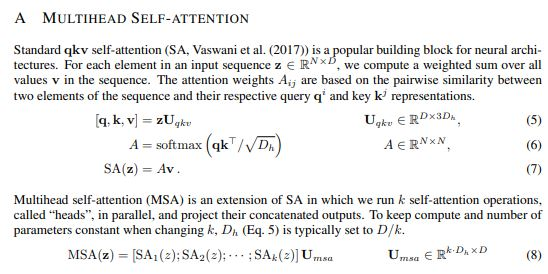

_Found in Appendix A of the ViT Research paper_

The image above illustrates the triple embedding inputs to the MSA layer, known as query, key, and value (qkv), which are fundamental to the self-attention mechanism. In our case, these three inputs are different versions of the output from the normalization layer—specifically, the layer-normalized image patch and position embeddings.

We can implement the MSA layer in PyTorch using `torch.nn.MultiheadAttention()` with the following parameters:

* `embed_dim`: the embedding dimension (hidden size $D$) from Table 1
* `num_heads`: the number of attention heads, also from Table 1
* `dropout`: whether to apply dropout (Appendix B.1 notes dropout isn't used after qkv projections)
* `batch_first`: indicates if the batch dimension comes first (which it does)


Now let's replicate equation 2 with PyTorch layers.

We will:
1. Create an MSA class that inherits from `torch.nn.Module`.
2. Initialize this class with hyperparameters from Table 1 of the ViT paper for the ViT-Base model.
3. Create a LayerNorm layer with `torch.nn.LayerNorm()` with the parameter `normalized_shape` equal to our embedding dimension $(D)$.
4. Create an MSA layer with `torch.nn.MultiheadAttention()`.
5. Create a `forward()` method that passes the inputs through the layers above.


In [69]:
# 1. Define a class for the Multi-Head Self-Attention block, inheriting from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    # 2. Initialize the block with key hyperparameters (based on ViT-Base from Table 1)
    def __init__(self,
                 embedding_dim: int = 768,   # Embedding dimension (D) from ViT-Base
                 num_heads: int = 12,        # Number of attention heads
                 attn_dropout: float = 0):   # Dropout for attention (not used in original ViT)
        super().__init__()

        # 3. Layer normalization applied before attention (Pre-LN setup)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Multi-head self-attention layer (with batch as the first dimension)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)  # Input format: [batch_size, seq_len, embed_dim]

    # 5. Forward method: normalize input, then apply multi-head self-attention
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,  # same input for query
                                             key=x,     # key
                                             value=x,   # and value (self-attention)
                                             need_weights=False)  # output attention weights not needed here
        return attn_output

MSA Block is now created. Let's pass our `patch_and_position_embedding` variable through an instance of our `MultiheadSelfAttentionBlock`.


In [70]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


The shape of our data stays the same when it goes through the MSA block, but that doesn't mean the values remain unchanged. You can print the tensor before and after passing it through the block to observe the differences.


Alright, our MSA block is created. Let's move on to building the MLP block!

# Replicating Equation 3

If you recall equation 3:

$$
\begin{aligned}
\mathbf{z}_{\ell} &= \operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right) + \mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L
\end{aligned}
$$

MLP stands for "multilayer perceptron" and LN stands for "layer normalization" (as discussed above).

The addition at the end is the skip/residual connection.


In the Vision Transformer (ViT), the **MLP block** consists of two linear layers with a **GELU** activation function in between. Dropout is applied after each linear layer to help prevent overfitting.

The sequence of operations is:
LayerNorm -> Linear -> GELU -> Dropout -> Linear -> Dropout


- The **linear layers** are implemented using `torch.nn.Linear()`.
- The **activation function** uses `torch.nn.GELU()`.
- The **dropout layers** use `torch.nn.Dropout()`, typically with a dropout probability of **0.1** (as specified in Table 3 of the ViT paper).
- The **hidden size (MLP size)** and **output size (embedding dimension D)** correspond to values from Table 1 in the ViT paper.

> **Note:**  
> Although "MLP" generally refers to any multi-layer perceptron, in the ViT context it specifically refers to this two-layer feed-forward network within the Transformer architecture.


Let's now replicate the MLP layer using PyTorch.

We will:

1. Create a class called `MLPBlock` that subclasses `torch.nn.Module`.
2. Initialize the class using hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
3. Define a Layer Normalization (`LayerNorm`) layer with `torch.nn.LayerNorm()`, setting the `normalized_shape` parameter equal to the embedding dimension \(D\).
4. Build a sequential MLP consisting of:
   - A linear layer (`torch.nn.Linear`) projecting from \(D\) to the MLP hidden size,
   - A GELU activation (`torch.nn.GELU`),
   - Dropout (`torch.nn.Dropout`) with the probability specified in Table 3,
   - Another linear layer projecting back from the MLP hidden size to ($D$),
   - A final dropout layer.
5. Implement the `forward()` method to pass inputs through the LayerNorm and the MLP sequential layers.


In [71]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3 for the ViT-Base model of the ViT Paper
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the MLP layer
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout)
        )

    # 5. Create a forward() method to pass the data through the layers made up above
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

Let's now combine the Multi-Head Self-Attention (MSA) block and the MLP block to create a Transformer Encoder block.


In [72]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSA Block through the MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


The shape of our data remains the same after passing through the MLP block; however, the values do change.  
To observe these changes, you can print the tensor before and after passing it through the block and compare the results.


Let's now combine the Multi-Head Self-Attention (MSA) block and the MLP block to build a Transformer Encoder.

**Note:**  
If you noticed, we haven't implemented the residual connections yet when recreating Equation 2 (MSA Block) and Equation 3 (MLP Block).  
We will add these residual connections in the next section when constructing the Transformer Encoder.


# Replicating the Transformer Encoder

In the Vision Transformer (ViT), the Transformer Encoder is constructed by stacking alternating Multi-Head Self-Attention (MSA) and MLP blocks.  
Each block is preceded by a Layer Normalization (LayerNorm) layer and followed by a residual (skip) connection.

Residual connections, first introduced in the ResNet paper, add a block’s input back to its output.  
This technique helps stabilize training by preserving gradient flow and enables the training of deeper networks.

Specifically, in ViT:  
- The input to the MSA block is added to its output before being passed to the MLP block.  
- Similarly, the input to the MLP block is added to its output before moving on to the next encoder layer.

This architecture allows the encoder to progressively learn richer and more meaningful representations of the input image patches.


Let's create the Transformer Encoder now. Here’s what we will do:

1. Create a class called `TransformerEncoderBlock` that subclasses `torch.nn.Module`.
2. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
3. Instantiate the MSA block for Equation 2 using the previously created `MultiheadSelfAttentionBlock`.
4. Instantiate the MLP block for Equation 3 using the previously created `MLPBlock`.
5. Implement the `forward()` method for the `TransformerEncoderBlock` class.
6. Add a residual connection around the MSA block (Equation 2).
7. Add a residual connection around the MLP block (Equation 3).


In [73]:
# 1. Define the Transformer Encoder block class
class TransformerEncoderBlock(nn.Module):
    # 2. Initialize with the necessary hyperparameters
    def __init__(self,
                 embedding_dim: int = 768,  # Embedding dimension (D) for ViT-Base
                 num_heads: int = 12,       # Number of attention heads
                 mlp_size: int = 3072,      # Hidden layer size inside the MLP block
                 mlp_dropout: float = 0.1,  # Dropout rate after linear layers in MLP
                 attn_dropout: float = 0):  # Dropout rate inside the attention mechanism
        super().__init__()

        # 3. Initialize the Multi-Head Self-Attention block
        self.msa_block = MultiheadSelfAttentionBlock(
            embedding_dim=embedding_dim,
            num_heads=num_heads,
            attn_dropout=attn_dropout
        )

        # 4. Initialize the MLP block
        self.mlp_block = MLPBlock(
            embedding_dim=embedding_dim,
            mlp_size=mlp_size,
            dropout=mlp_dropout
        )

    # 5. Define the forward pass through the encoder block
    def forward(self, x):

        # 6. Apply MSA block with residual connection
        x = self.msa_block(x) + x

        # 7. Apply MLP block with residual connection
        x = self.mlp_block(x) + x

        return x


Transformer Encoder Block created successfully!


If you recall, the **Layers** column in Table 1 of the ViT paper refers to the number of Transformer Encoder blocks in a given ViT architecture.

Since we are replicating the ViT-Base model, we will stack **12 Transformer Encoder blocks** to form the core of our model.


Now for the moment you’ve all been waiting for — let’s build the Vision Transformer (ViT) architecture by combining:

- The Patch Embedding layer  
- The learnable class token  
- Positional embeddings  
- Our stack of Transformer Encoder blocks  

We will also add the MLP Head (classifier layer) once we create it, which we will cover in the next section.


# Putting it All Together

You might be wondering why we haven't replicated Equation 4 yet. Recall Equation 4:

$$
\mathbf{y} = \operatorname{LN}\left(\mathbf{z}_L^0\right)
$$

We will implement this in the architecture to convert the 0th index (\(\mathbf{z}_L^0\)) of the Transformer Encoder’s output logits to the target number of classes.

To create the full Vision Transformer architecture, we need to stack multiple `TransformerEncoderBlock`s.  
We can do this by passing a list of these blocks to `torch.nn.Sequential()`, creating a sequential chain of Transformer Encoder blocks.  
For the ViT-Base model, this stack consists of **12 Transformer Encoder blocks**.

---

### Steps to build the Vision Transformer (ViT) architecture:

1. Create a class called `ViT` that subclasses `torch.nn.Module`.  
2. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.  
3. Verify that the input image size is divisible by the patch size to ensure even splitting into patches.  
4. Calculate the number of patches using:  
   \[
   N = \frac{H \times W}{P^2}
   \]
   where \(H\) = image height, \(W\) = image width, and \(P\) = patch size.  
5. Create a learnable **class embedding token** (Equation 1).  
6. Create a learnable **positional embedding vector** (Equation 2).  
7. Set up an embedding dropout layer as described in Appendix B.1 of the ViT paper.  
8. Create the **patch embedding layer** using the `PatchEmbedding` module created earlier.  
9. Create a series of Transformer Encoder blocks by passing a list of `TransformerEncoderBlock`s to `torch.nn.Sequential()` (Equations 2 and 3).  
10. Initialize the **MLP Head** (classifier head, Equation 4) using a `torch.nn.Sequential()` containing:  
    - A `torch.nn.LayerNorm()` layer, and  
    - A `torch.nn.Linear(out_features=num_classes)` layer, where `num_classes` is the number of target classes.  
11. Define the `forward()` method to accept input images.  
12. Extract the batch size from the input (the first dimension of the input tensor shape).  
13. Pass the input through the patch embedding layer (step 8).  
14. Create the class token embedding (step 5) and expand it across the batch dimension using `torch.Tensor.expand()`.  
15. Concatenate the class token embedding to the beginning of the patch embeddings using `torch.cat()` (Equation 1).  
16. Add the positional embedding (step 6) to the combined patch and class token embeddings.  
17. Pass the result through the dropout layer (step 7).  
18. Pass this embedding through the stack of Transformer Encoder blocks (step 9, Equations 2 & 3).  
19. Take the output at index 0 (corresponding to the class token) and pass it through the classifier head created in step 10 (Equation 4).  


In [74]:
# 1. Define the ViT class, inheriting from nn.Module
class ViT(nn.Module):
    """Vision Transformer (ViT-Base) implementation based on the original paper."""

    # 2. Initialize the class with ViT-Base hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size: int = 224,         # Image input size (e.g., 224x224)
                 in_channels: int = 3,        # Number of input channels (e.g., RGB = 3)
                 patch_size: int = 16,        # Size of each image patch (P)
                 num_transformer_layers: int = 12,  # Number of Transformer blocks (L)
                 embedding_dim: int = 768,    # Dimension of embedding (D)
                 mlp_size: int = 3072,        # Hidden layer size in MLP (MLP size)
                 num_heads: int = 12,         # Number of self-attention heads (H)
                 attn_dropout: float = 0.0,   # Dropout in attention projection (usually 0)
                 mlp_dropout: float = 0.1,    # Dropout in MLP layers
                 embedding_dropout: float = 0.1,  # Dropout after adding position embedding
                 num_classes: int = 1000):    # Number of output classes
        super().__init__()

        # 3. Ensure the image size is divisible by the patch size
        assert img_size % patch_size == 0, f"Image size ({img_size}) must be divisible by patch size ({patch_size})"

        # 4. Compute total number of patches: N = (H * W) / P^2
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Learnable class token (prepended to patch embeddings)
        self.class_embedding = nn.Parameter(torch.randn(1, 1, embedding_dim))

        # 6. Learnable positional embeddings (added to patch + class embeddings)
        self.position_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, embedding_dim))

        # 7. Dropout applied after adding positional embeddings (Appendix B.1)
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Patch embedding layer (image → flattened patch → linear projection)
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Stack of Transformer Encoder blocks (equations 2 and 3)
        self.transformer_encoder = nn.Sequential(*[
            TransformerEncoderBlock(embedding_dim=embedding_dim,
                                    num_heads=num_heads,
                                    mlp_size=mlp_size,
                                    mlp_dropout=mlp_dropout)
            for _ in range(num_transformer_layers)
        ])

        # 10. Classification head: LayerNorm followed by linear projection (equation 4)
        self.classifier = nn.Sequential(
            nn.LayerNorm(embedding_dim),
            nn.Linear(embedding_dim, num_classes)
        )

    # 11. Define the forward pass
    def forward(self, x):
        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Expand class token across batch dimension
        class_token = self.class_embedding.expand(batch_size, -1, -1)

        # 14. Apply patch embedding to input image
        x = self.patch_embedding(x)

        # 15. Concatenate class token with patch embeddings along sequence dimension
        x = torch.cat((class_token, x), dim=1)

        # 16. Add positional embeddings
        x = x + self.position_embedding

        # 17. Apply dropout to the embeddings
        x = self.embedding_dropout(x)

        # 18. Pass through the Transformer encoder
        x = self.transformer_encoder(x)

        # 19. Apply classification head to the [CLS] token (index 0)
        x = self.classifier(x[:, 0])

        return x


We just built a vision transformer!!!

Let's try out our `ViT` class by creating a random tensor that mimics the shape of a single image in our situation.  
Then, we'll pass this tensor through an instance of our `ViT` class.


In [75]:
# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with which is 6 in our case
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[ 0.0166,  0.2157, -0.9969, -0.8019,  0.9281,  0.1116]],
       grad_fn=<AddmmBackward0>)

Great! It works! We’ve successfully created a functioning Vision Transformer!

Let's use `torchinfo.summary()` to get a visual overview of the layers in our architecture, including how the input and output shapes change as data passes through them.


First install torchinfo using this cell below

In [80]:
# uncomment to install
#!pip install torchinfo

In [81]:
from torchinfo import summary

# # Print a summary of our custom ViT model using torchinfo
summary(model=vit,
         input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"]
 )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 6]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

That is a lot of layers and parameters! Notice how the input and output shapes change throughout the network.  

At the end, we receive an output shape of `(32, 6)`, which corresponds to the logits for each of the 6 classes in our dataset, for a batch size of 32.


Alright, let’s train this model on our Kaggle dataset!


# Training

## Create a train step function

In [89]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # output model logits

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    #5. Optimizer step
    optimizer.step()

    # Calculate the accuracy
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += ((y_pred_class == y).sum().item()/len(y_pred))

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss/ len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

## Create a test step function

In [90]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels==y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

## Create a training loop function

In [91]:
from tqdm.auto import tqdm

# 1. Create a train function taht takes in various model parameters + optimizer + dataloaders  + loss function
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):
  # 2. Create empty results dictionary
  results ={"train_loss": [],
            "train_acc": [],
            "test_loss": [],
            "test_acc": []}

  # 3. Loop through and training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of the epochs
  return results

## Setting up our optimizer and loss function

In section 4.1 of the ViT paper states that:

"Training & Fine-tuning. We train all models, including ResNets, using Adam (Kingma & Ba, 2015 ) with  β1=0.9,β2=0.999 , a batch size of 4096 and apply a high weight decay of  0.1 , which we found to be useful for transfer of all models (Appendix D.1 shows that, in contrast to common practices, Adam works slightly better than SGD for ResNets in our setting)."

They used the "Adam" optimizer which we can create using `torch.optim.Adam()`

The authors set Adam's $\beta$ (beta) values to $\beta_{1}=0.9, \beta_{2}=0.999$, these are the default values for the `betas` parameter in `torch.optim.Adam(betas=(0.9, 0.999))`.

They also state the utilization of [weight decay] (slowly reducing the values of the weights during optimization to prevent overfitting), we can set this with the `weight_decay` parameter in `torch.optim.Adam(weight_decay=0.3)` (according to the setting of ViT-* trained on ImageNet-1k).

We'll make the learning rate of the optimizer to 0.003 as per Table 3 (according to the setting of ViT-* trained on ImageNet-1k).

And as discussed previously, we're going to use a lower batch size than 4096 due to hardware limitations (if you have a large GPU, feel free to increase the batch size).

Since the ViT paper does not explicitly specify the loss function used, and because we are dealing with a multi-class classification problem, we will use PyTorch’s built-in `torch.nn.CrossEntropyLoss()` as our loss function.

This loss function is well-suited for classification tasks where the model outputs logits and the target is a class index.


In [92]:
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

Let's start training!

**Note:** Training is recommended on a GPU for faster performance. Google Colab offers a free-tier GPU, which you can enable by going to Runtime > Change runtime type and selecting GPU from the dropdown. Keep in mind that GPU access is limited and may time out, and switching to GPU will reset your current runtime, so make sure to save your progress before doing so.



In [93]:
results = train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.8788 | Train acc: 0.1632 | Test loss: 1.7936 | Test acc: 0.1692
Epoch: 1 | Train loss: 1.7919 | Train acc: 0.1757 | Test loss: 1.7914 | Test acc: 0.1745
Epoch: 2 | Train loss: 1.7914 | Train acc: 0.1765 | Test loss: 1.7905 | Test acc: 0.1745
Epoch: 3 | Train loss: 1.7913 | Train acc: 0.1734 | Test loss: 1.7911 | Test acc: 0.1692
Epoch: 4 | Train loss: 1.7915 | Train acc: 0.1725 | Test loss: 1.7911 | Test acc: 0.1745
Epoch: 5 | Train loss: 1.7913 | Train acc: 0.1756 | Test loss: 1.7913 | Test acc: 0.1838
Epoch: 6 | Train loss: 1.7915 | Train acc: 0.1740 | Test loss: 1.7907 | Test acc: 0.1745
Epoch: 7 | Train loss: 1.7914 | Train acc: 0.1778 | Test loss: 1.7907 | Test acc: 0.1745
Epoch: 8 | Train loss: 1.7914 | Train acc: 0.1724 | Test loss: 1.7908 | Test acc: 0.1745
Epoch: 9 | Train loss: 1.7913 | Train acc: 0.1769 | Test loss: 1.7907 | Test acc: 0.1745


We finished training!

The results might not seem great because we are missing a couple of things. The original ViT architecture achieved strong results thanks to training on massive datasets with a complex training scheme—including large batch sizes, learning rate warmup and decay, and gradient clipping—to prevent overfitting. Our implementation uses much less data, smaller batch sizes, and simpler training without these techniques, which explains why our results aren’t as good despite using the same architecture. Many advanced training methods in the original paper are tailored to handle the model’s size and extensive data, helping it learn effectively without overfitting.

The main goal of this notebook was to show how to build a fully functioning Vision Transformer based on the original research paper—and we’ve done exactly that! Give yourself a pat on the back; you’ve just created a Vision Transformer from scratch!